In [0]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
import random
from sklearn.metrics import confusion_matrix
from keras import optimizers
import matplotlib.pyplot as plt
import sklearn
from keras.optimizers import Adam

import pandas as pd
import io
import requests
import warnings

#import deepchem as dc
#import deepchem.models.tensorgraph.layers as layers
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten

warnings.filterwarnings("ignore")    

In [0]:
#url="https://raw.githubusercontent.com/atfrank/CS-Annotate/master/data/train_features.csv"
url = "https://raw.githubusercontent.com/atfrank/CS-Annotate/Kexin/data/train_features_3.csv"
s=requests.get(url).content
training_X = pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ' ')
#url = "https://raw.githubusercontent.com/atfrank/CS-Annotate/master/data/train_target.csv"
url = "https://raw.githubusercontent.com/atfrank/CS-Annotate/Kexin/data/train_target_3.csv"
s=requests.get(url).content
training_y = pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ' ')
#url="https://raw.githubusercontent.com/atfrank/CS-Annotate/master/data/test_features.csv"
url = "https://raw.githubusercontent.com/atfrank/CS-Annotate/Kexin/data/test_features_3.csv"
s=requests.get(url).content
testing_X = pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ' ')
#url = "https://raw.githubusercontent.com/atfrank/CS-Annotate/master/data/test_target.csv"
url = "https://raw.githubusercontent.com/atfrank/CS-Annotate/Kexin/data/test_target_3.csv"
s=requests.get(url).content
testing_y = pd.read_csv(io.StringIO(s.decode('utf-8')), sep = ' ')
from keras import backend as K

#Define recall by the ratio of true positive to possible positives. k.epsilon is a fuzzy constant used to prevent dividing by 0
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

#Define precision as the ratio of true positives to predicted positives
def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

#Define f1 score as the ratio of the product to the sum of precision and recall, scaled by 2
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Train on 2454 samples, validate on 614 samples
Epoch 1/10
2454/2454 [==============================] - 1s 223us/step - loss: 74.0014 - accuracy: 0.5383 - f1_m: 0.5595 - precision_m: 0.6536 - recall_m: 0.5554 - val_loss: 71.0746 - val_accuracy: 0.7117 - val_f1_m: 0.8126 - val_precision_m: 0.7973 - val_recall_m: 0.8479
Epoch 2/10
2454/2454 [==============================] - 0s 141us/step - loss: 72.0679 - accuracy: 0.6255 - f1_m: 0.6877 - precision_m: 0.7579 - recall_m: 0.7057 - val_loss: 71.0100 - val_accuracy: 0.2704 - val_f1_m: 0.1441 - val_precision_m: 0.8375 - val_recall_m: 0.0799
Epoch 3/10
2454/2454 [==============================] - 0s 134us/step - loss: 71.6222 - accuracy: 0.5249 - f1_m: 0.5272 - precision_m: 0.7786 - recall_m: 0.5018 - val_loss: 70.4859 - val_accuracy: 0.7899 - val_f1_m: 0.8744 - val_precision_m: 0.8202 - val_recall_m: 0.9497
Epoch 4/10
2454/2454 [==============================] - 0s 146us/step - loss: 71.1607 - accuracy: 0.6100 - f1_m: 0.6612 - precision_m: 0.

<Figure size 432x288 with 0 Axes>

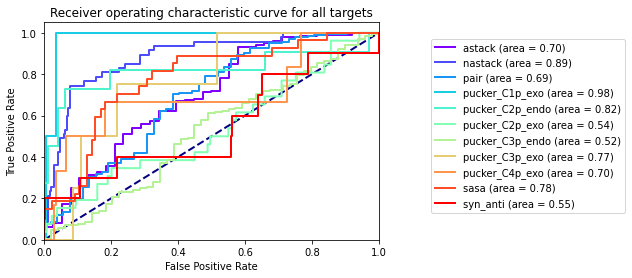

In [94]:
Total_Data = pd.DataFrame(columns = ['Parameter','F1-score'])

import matplotlib.cm as cm

feature_list = ['astack','nastack','pair','pucker_C1p_exo','pucker_C2p_endo','pucker_C2p_exo','pucker_C3p_endo','pucker_C3p_exo','pucker_C4p_exo','sasa','syn_anti']
colors = cm.rainbow(np.linspace(0, 1, len(feature_list)))

i=0
plt.figure()
lw = 2
__, ax = plt.subplots()
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

for structural_feature in feature_list:
  #Can put data link here:
  
  trainX = training_X.values
  training_y_2 = training_y[[structural_feature]]
  amira = training_y_2[f'{structural_feature}'].value_counts()
  custom_weights = {0:amira[1]*0.1, 1:amira[0]*0.1}
  trainy = training_y_2.values


  testX = testing_X.values


  testing_y_2 = testing_y[[structural_feature]]
  testy = testing_y_2.values
  #stack (1) and non-stack (0)

  #Due to keras not having f1 score, recall, and precision built in, it must be defined. Use keras backend for shortening code

  scaler = StandardScaler()
  scaler.fit(trainX)
  trainX_scaled = scaler.transform(trainX)
  testX_scaled = scaler.transform(testX)

  #The data needs to have its dimensions expanded in order to be put into the 1d convolution
  trainX_expanded = np.expand_dims(trainX, axis=2)
  testX_expanded = np.expand_dims(testX, axis=2)

  #Creating each layer. Only using one conv1d layer because the vector is small and the patterns may not be relevant due to arbitrary ordering of chemical shifts
  model = Sequential()
  model.add(Conv1D(filters=6, kernel_size=5, activation='sigmoid', input_shape=(trainX_expanded.shape[1],trainX_expanded.shape[2])))
  model.add(Dropout(0.5))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(50, activation='sigmoid'))
  model.add(Dense(trainX_expanded.shape[2], activation = 'sigmoid'))

  model.compile(loss='binary_crossentropy',optimizer= 'adam', metrics=['accuracy', f1_m,precision_m, recall_m])

  model.fit(trainX_expanded, trainy, class_weight = custom_weights, nb_epoch = 10, batch_size = 32, verbose = 1, validation_split = 0.2)

  y_pred = model.predict(testX_expanded)
  y_pred = np.float64(y_pred)
  y_true = np.array([testy[i][0] for i in range(len(testy))])
  y_pred = np.array([y_pred[i][0] for i in range(len(y_pred))])
  f1 = f1_m(y_true,y_pred).numpy()
  temp = pd.DataFrame([[structural_feature,f1]], columns = ['Parameter','F1-score'])
  Total_Data = Total_Data.append(temp)

  AUC = sklearn.metrics.roc_auc_score(y_true, y_pred, average = 'weighted')
  fpr,tpr,thresholds = sklearn.metrics.roc_curve(y_true, y_pred, pos_label = 1)
  
  ax.plot(fpr, tpr, color=colors[i],
          lw=lw, label=f'{structural_feature} (area = %0.2f)' % AUC)
  
  i+=1

print(Total_Data)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve for all targets')
plt.legend(loc="lower right", bbox_to_anchor=(1.75, 0.1))
plt.show()